# AlphaFold

This Notebook is based on the [Colab notebook](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) provided by Deepmind and has been adapted by Thomas Chaussepied (IFB) and Julien Seiler (IGBMC/IFB).

This notebook allows you to easily predict the structure of a protein using a slightly simplified version of [AlphaFold v2.0](https://doi.org/10.1038/s41586-021-03819-2).

This notebook is not using as many genetic databases as the command line version available through the `alphafold/2.0.1` module.

**Citing this work**

Any publication that discloses findings arising from using this notebook should [cite](https://github.com/deepmind/alphafold/#citing-this-work) the [AlphaFold paper](https://doi.org/10.1038/s41586-021-03819-2).

**Licenses**

This Colab uses the [AlphaFold model parameters](https://github.com/deepmind/alphafold/#model-parameters-license) and its outputs are thus for non-commercial use only, under the Creative Commons Attribution-NonCommercial 4.0 International ([CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/legalcode)) license. The Colab itself is provided under the [Apache 2.0 license](https://www.apache.org/licenses/LICENSE-2.0). See the full license statement below.

**More information**

You can find more information about how AlphaFold works in our two Nature papers:

*   [AlphaFold methods paper](https://www.nature.com/articles/s41586-021-03819-2)
*   [AlphaFold predictions of the human proteome paper](https://www.nature.com/articles/s41586-021-03828-1)

FAQ on how to interpret AlphaFold predictions are [here](https://alphafold.ebi.ac.uk/faq).

## Preparing environment

To allow best performances, this script uses a local ramdisk.

In [17]:
!mkdir -m 777 --parents /dev/shm/alphafold
!ln -s /dev/shm/alphafold /tmp/ramdisk

## Making a prediction

In [18]:
import ipywidgets as widgets
from IPython.display import display
w_sequence = widgets.Text(
    placeholder = 'Enter the amino acid sequence to fold',
    description = 'Sequence:',
    disabled = False,
    layout = widgets.Layout(width='auto')
)
display(w_sequence)

Text(value='', description='Sequence:', layout=Layout(width='auto'), placeholder='Enter the amino acid sequenc…

Note that the search against databases and the actual prediction can take some time, from minutes to hours, depending on the length of the protein and what type of GPU you are allocated.

### Controlling the amino acid sequence

In [19]:
# sample sequence : MAAHKGAEHHHKAAEHHEQAAKHHHAAAEHHEKGEHEQAAHHADTAYAHHKHAEEHAAQAAKHDAEHHAPKPH
sequence = w_sequence.value

MIN_SEQUENCE_LENGTH = 16
MAX_SEQUENCE_LENGTH = 2500

# Remove all whitespaces, tabs and end lines; upper-case
sequence = sequence.translate(str.maketrans('', '', ' \n\t')).upper()
aatypes = set('ACDEFGHIKLMNPQRSTVWY')  # 20 standard aatypes
if not set(sequence).issubset(aatypes):
  raise Exception(f'Input sequence contains non-amino acid letters: {set(sequence) - aatypes}. AlphaFold only supports 20 standard amino acids as inputs.')
if len(sequence) < MIN_SEQUENCE_LENGTH:
  raise Exception(f'Input sequence is too short: {len(sequence)} amino acids, while the minimum is {MIN_SEQUENCE_LENGTH}')
if len(sequence) > MAX_SEQUENCE_LENGTH:
  raise Exception(f'Input sequence is too long: {len(sequence)} amino acids, while the maximum is {MAX_SEQUENCE_LENGTH}. Please use the full AlphaFold system for long sequences.')

### Search against genetic databases

Once this cell has been executed, you will see statistics about the multiple sequence alignment (MSA) that will be used by AlphaFold. In particular, you’ll see how well each residue is covered by similar sequences in the MSA.

  0%|          | 0/3 [elapsed: 00:00 remaining: ?]

56 Sequences Found in uniref90
95 Sequences Found in smallbfd
57 Sequences Found in mgnify

203 Sequences Found in Total



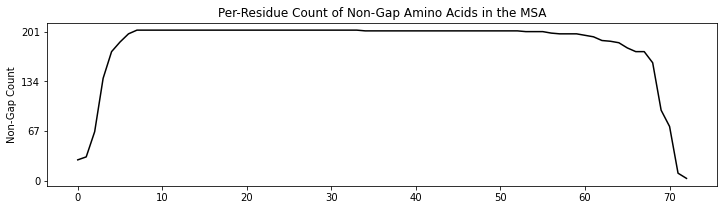

In [20]:
import os
os.environ['TF_FORCE_UNIFIED_MEMORY'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '2.0'

from urllib import request
from concurrent import futures
import json
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol

from alphafold.model import model
from alphafold.model import config
from alphafold.model import data

from alphafold.data import parsers
from alphafold.data import pipeline
from alphafold.data.tools import jackhmmer

from alphafold.common import protein

from alphafold.relax import relax
from alphafold.relax import utils

from IPython import display
from ipywidgets import GridspecLayout
from ipywidgets import Output

from tqdm.notebook import trange, tqdm

# Color bands for visualizing plddt
PLDDT_BANDS = [(0, 50, '#FF7D45'),
               (50, 70, '#FFDB13'),
               (70, 90, '#65CBF3'),
               (90, 100, '#0053D6')]

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

# --- Search against genetic databases ---
with open('target.fasta', 'wt') as f:
  f.write(f'>query\n{sequence}')

# Run the search against chunks of genetic databases (since the genetic
# databases don't fit in Colab ramdisk).

jackhmmer_binary_path = '/shared/software/miniconda3-admin/envs/alphafold-2.0.1/bin/jackhmmer'
dbs = []

num_jackhmmer_chunks = {'uniref90': 1, 'smallbfd': 1, 'mgnify': 1}
total_jackhmmer_chunks = sum(num_jackhmmer_chunks.values())
with tqdm(total=3, bar_format=TQDM_BAR_FORMAT) as pbar:

  pbar.set_description('Searching uniref90')
  jackhmmer_uniref90_runner = jackhmmer.Jackhmmer(
      binary_path=jackhmmer_binary_path,
      database_path=f'/mnt/alphafold/uniref90/uniref90.fasta',
      get_tblout=True,
      n_cpu=12,
      z_value=135301051)
  dbs.append(('uniref90', jackhmmer_uniref90_runner.query('target.fasta')))
  pbar.update(n=1)


  pbar.set_description('Searching smallbfd')
  jackhmmer_smallbfd_runner = jackhmmer.Jackhmmer(
      binary_path=jackhmmer_binary_path,
      database_path=f'/mnt/alphafold/small_bfd/bfd-first_non_consensus_sequences.fasta',
      get_tblout=True,
      n_cpu=12,
      z_value=65984053)
  dbs.append(('smallbfd', jackhmmer_smallbfd_runner.query('target.fasta')))
  pbar.update(n=1)

  pbar.set_description('Searching mgnify')
  jackhmmer_mgnify_runner = jackhmmer.Jackhmmer(
      binary_path=jackhmmer_binary_path,
      database_path=f'/mnt/alphafold/mgnify/mgy_clusters_2018_12.fa',
      get_tblout=True,
      n_cpu=12,
      z_value=304820129)
  dbs.append(('mgnify', jackhmmer_mgnify_runner.query('target.fasta')))
  pbar.update(n=1)


# --- Extract the MSAs and visualize ---
# Extract the MSAs from the Stockholm files.
# NB: deduplication happens later in pipeline.make_msa_features.

mgnify_max_hits = 501

msas = []
deletion_matrices = []
full_msa = []
for db_name, db_results in dbs:
  unsorted_results = []
  for i, result in enumerate(db_results):
    msa, deletion_matrix, target_names = parsers.parse_stockholm(result['sto'])
    e_values_dict = parsers.parse_e_values_from_tblout(result['tbl'])
    e_values = [e_values_dict[t.split('/')[0]] for t in target_names]
    zipped_results = zip(msa, deletion_matrix, target_names, e_values)
    if i != 0:
      # Only take query from the first chunk
      zipped_results = [x for x in zipped_results if x[2] != 'query']
    unsorted_results.extend(zipped_results)
  sorted_by_evalue = sorted(unsorted_results, key=lambda x: x[3])
  db_msas, db_deletion_matrices, _, _ = zip(*sorted_by_evalue)
  if db_msas:
    if db_name == 'mgnify':
      db_msas = db_msas[:mgnify_max_hits]
      db_deletion_matrices = db_deletion_matrices[:mgnify_max_hits]
    full_msa.extend(db_msas)
    msas.append(db_msas)
    deletion_matrices.append(db_deletion_matrices)
    msa_size = len(set(db_msas))
    print(f'{msa_size} Sequences Found in {db_name}')

deduped_full_msa = list(dict.fromkeys(full_msa))
total_msa_size = len(deduped_full_msa)
print(f'\n{total_msa_size} Sequences Found in Total\n')

aa_map = {restype: i for i, restype in enumerate('ABCDEFGHIJKLMNOPQRSTUVWXYZ-')}
msa_arr = np.array([[aa_map[aa] for aa in seq] for seq in deduped_full_msa])
num_alignments, num_res = msa_arr.shape

fig = plt.figure(figsize=(12, 3))
plt.title('Per-Residue Count of Non-Gap Amino Acids in the MSA')
plt.plot(np.sum(msa_arr != aa_map['-'], axis=0), color='black')
plt.ylabel('Non-Gap Count')
plt.yticks(range(0, num_alignments + 1, max(1, int(num_alignments / 3))))
plt.show()

### Run AlphaFold and download prediction

Once this cell has been executed, a gzip-archive called `prediction.tgz` with the obtained prediction will be automatically saved in the same directory than this notebook.

  0%|          | 0/7 [elapsed: 00:00 remaining: ?]

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

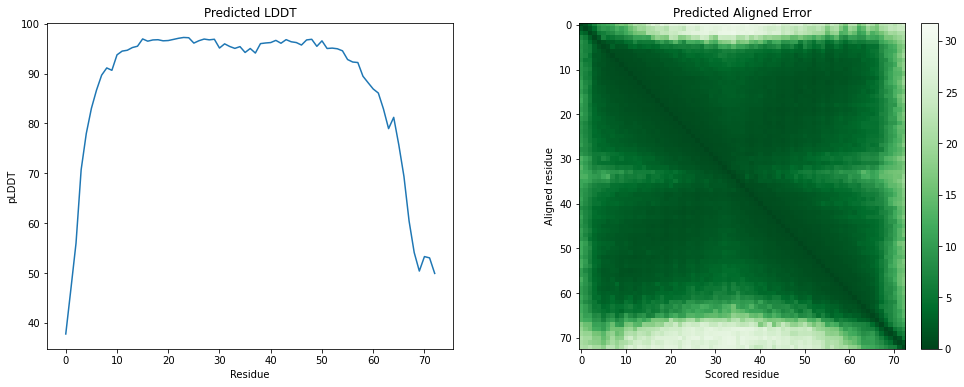

In [21]:
# --- Run the model ---
model_names = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_2_ptm']

def _placeholder_template_feats(num_templates_, num_res_):
  return {
      'template_aatype': np.zeros([num_templates_, num_res_, 22], np.float32),
      'template_all_atom_masks': np.zeros([num_templates_, num_res_, 37, 3], np.float32),
      'template_all_atom_positions': np.zeros([num_templates_, num_res_, 37], np.float32),
      'template_domain_names': np.zeros([num_templates_], np.float32),
      'template_sum_probs': np.zeros([num_templates_], np.float32),
  }

output_dir = 'prediction'
os.makedirs(output_dir, exist_ok=True)

plddts = {}
pae_outputs = {}
unrelaxed_proteins = {}

with tqdm(total=len(model_names) + 1, bar_format=TQDM_BAR_FORMAT) as pbar:
  for model_name in model_names:
    pbar.set_description(f'Running {model_name}')
    num_templates = 0
    num_res = len(sequence)

    feature_dict = {}
    feature_dict.update(pipeline.make_sequence_features(sequence, 'test', num_res))
    feature_dict.update(pipeline.make_msa_features(msas, deletion_matrices=deletion_matrices))
    feature_dict.update(_placeholder_template_feats(num_templates, num_res))

    cfg = config.model_config(model_name)
    params = data.get_model_haiku_params(model_name, '/mnt/alphafold')
    model_runner = model.RunModel(cfg, params)
    processed_feature_dict = model_runner.process_features(feature_dict,
                                                           random_seed=0)
    prediction_result = model_runner.predict(processed_feature_dict)

    mean_plddt = prediction_result['plddt'].mean()

    if 'predicted_aligned_error' in prediction_result:
      pae_outputs[model_name] = (
          prediction_result['predicted_aligned_error'],
          prediction_result['max_predicted_aligned_error']
      )
    else:
      # Get the pLDDT confidence metrics. Do not put pTM models here as they
      # should never get selected.
      plddts[model_name] = prediction_result['plddt']

    # Set the b-factors to the per-residue plddt.
    final_atom_mask = prediction_result['structure_module']['final_atom_mask']
    b_factors = prediction_result['plddt'][:, None] * final_atom_mask
    unrelaxed_protein = protein.from_prediction(processed_feature_dict,
                                                prediction_result,
                                                b_factors=b_factors)
    unrelaxed_proteins[model_name] = unrelaxed_protein

    # Delete unused outputs to save memory.
    del model_runner
    del params
    del prediction_result
    pbar.update(n=1)

  # --- AMBER relax the best model ---
  pbar.set_description(f'AMBER relaxation')
  amber_relaxer = relax.AmberRelaxation(
      max_iterations=0,
      tolerance=2.39,
      stiffness=10.0,
      exclude_residues=[],
      max_outer_iterations=20)
  # Find the best model according to the mean pLDDT.
  best_model_name = max(plddts.keys(), key=lambda x: plddts[x].mean())
  relaxed_pdb, _, _ = amber_relaxer.process(
      prot=unrelaxed_proteins[best_model_name])
  pbar.update(n=1)  # Finished AMBER relax.

# Construct multiclass b-factors to indicate confidence bands
# 0=very low, 1=low, 2=confident, 3=very high
banded_b_factors = []
for plddt in plddts[best_model_name]:
  for idx, (min_val, max_val, _) in enumerate(PLDDT_BANDS):
    if plddt >= min_val and plddt <= max_val:
      banded_b_factors.append(idx)
      break
banded_b_factors = np.array(banded_b_factors)[:, None] * final_atom_mask
to_visualize_pdb = utils.overwrite_b_factors(relaxed_pdb, banded_b_factors)


# Write out the prediction
pred_output_path = os.path.join(output_dir, 'selected_prediction.pdb')
with open(pred_output_path, 'w') as f:
  f.write(relaxed_pdb)


# --- Visualise the prediction & confidence ---
show_sidechains = True
def plot_plddt_legend():
  """Plots the legend for pLDDT."""
  thresh = [
            'Very low (pLDDT < 50)',
            'Low (70 > pLDDT > 50)',
            'Confident (90 > pLDDT > 70)',
            'Very high (pLDDT > 90)']

  colors = [x[2] for x in PLDDT_BANDS]

  plt.figure(figsize=(2, 2))
  for c in colors:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False, loc='center', fontsize=20)
  plt.xticks([])
  plt.yticks([])
  ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  plt.title('Model Confidence', fontsize=20, pad=20)
  return plt

# Color the structure by per-residue pLDDT
color_map = {i: bands[2] for i, bands in enumerate(PLDDT_BANDS)}
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(to_visualize_pdb)
style = {'cartoon': {
    'colorscheme': {
        'prop': 'b',
        'map': color_map}
        }}
if show_sidechains:
  style['stick'] = {}
view.setStyle({'model': -1}, style)
view.zoomTo()

grid = GridspecLayout(1, 2)
out = Output()
with out:
  view.show()
grid[0, 0] = out

out = Output()
with out:
  plot_plddt_legend().show()
grid[0, 1] = out

display.display(grid)

# Display pLDDT and predicted aligned error (if output by the model).
if pae_outputs:
  num_plots = 2
else:
  num_plots = 1

plt.figure(figsize=[8 * num_plots, 6])
plt.subplot(1, num_plots, 1)
plt.plot(plddts[best_model_name])
plt.title('Predicted LDDT')
plt.xlabel('Residue')
plt.ylabel('pLDDT')

if num_plots == 2:
  plt.subplot(1, 2, 2)
  pae, max_pae = list(pae_outputs.values())[0]
  plt.imshow(pae, vmin=0., vmax=max_pae, cmap='Greens_r')
  plt.colorbar(fraction=0.046, pad=0.04)
  plt.title('Predicted Aligned Error')
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

# Save pLDDT and predicted aligned error (if it exists)
pae_output_path = os.path.join(output_dir, 'predicted_aligned_error.json')
if pae_outputs:
  # Save predicted aligned error in the same format as the AF EMBL DB
  rounded_errors = np.round(pae.astype(np.float64), decimals=1)
  indices = np.indices((len(rounded_errors), len(rounded_errors))) + 1
  indices_1 = indices[0].flatten().tolist()
  indices_2 = indices[1].flatten().tolist()
  pae_data = json.dumps([{
      'residue1': indices_1,
      'residue2': indices_2,
      'distance': rounded_errors.flatten().tolist(),
      'max_predicted_aligned_error': max_pae.item()
  }],
                        indent=None,
                        separators=(',', ':'))
  with open(pae_output_path, 'w') as f:
    f.write(pae_data)


# --- Download the predictions ---
!tar czf {output_dir}.tgz {output_dir}

### Interpreting the prediction

Please see the [AlphaFold methods paper](https://www.nature.com/articles/s41586-021-03819-2) and the [AlphaFold predictions of the human proteome paper](https://www.nature.com/articles/s41586-021-03828-1), as well as [our FAQ](https://alphafold.ebi.ac.uk/faq) on how to interpret AlphaFold predictions.

## AlphaFold Code License

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0.

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Model Parameters License

The AlphaFold parameters are made available for non-commercial use only, under the terms of the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. You can find details at: https://creativecommons.org/licenses/by-nc/4.0/legalcode


## Third-party software

Use of the third-party software, libraries or code referred to in the [Acknowledgements section](https://github.com/deepmind/alphafold/#acknowledgements) in the AlphaFold README may be governed by separate terms and conditions or license provisions. Your use of the third-party software, libraries or code is subject to any such terms and you should check that you can comply with any applicable restrictions or terms and conditions before use.


## Mirrored Databases

The following databases have been mirrored by DeepMind, and are available with reference to the following:
* UniRef90: v2021\_03 (unmodified), by The UniProt Consortium, available under a [Creative Commons Attribution-NoDerivatives 4.0 International License](http://creativecommons.org/licenses/by-nd/4.0/).
* MGnify: v2019\_05 (unmodified), by Mitchell AL et al., available free of all copyright restrictions and made fully and freely available for both non-commercial and commercial use under [CC0 1.0 Universal (CC0 1.0) Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/).
* BFD: (modified), by Steinegger M. and Söding J., modified by DeepMind, available under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by/4.0/). See the Methods section of the [AlphaFold proteome paper](https://www.nature.com/articles/s41586-021-03828-1) for details.